# Isolate Events based on Scattering and Final Lepton Energy
All cuts used in all plots (Lepton pt, ke, angle)

In [1]:
## Import statements ##
import numpy as np
import pandas as pd
from particle import Particle
import matplotlib.pyplot as plt
from scipy.stats import chisquare

In [2]:
## Plot settings ##
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 20,
    'legend.loc':'upper left',
    'axes.labelsize': 'small',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small', 
         'lines.markersize': 10}
pylab.rcParams.update(params)


In [17]:
## Read in necessary dataframes (fp: final particles, ip: initial particles, sm all other columns) ##
gst_fp_df = pd.read_hdf("/Users/laurazichi/Desktop/Fermilab/base_generation_with_weights_13Jun_FSIFix.hdf", "gst_fp_df")
gst_ip_df = pd.read_hdf("/Users/laurazichi/Desktop/Fermilab/base_generation_with_weights_13Jun_FSIFix.hdf", "gst_ip_df")
gst_df = pd.read_hdf("/Users/laurazichi/Desktop/Fermilab/base_generation_with_weights_13Jun_FSIFix.hdf", "gst_df")

In [18]:
wghts = ['wght_FrCEx_N_n1', 'wght_FrCEx_N_p1', 'wght_FrAbs_N_n1', 'wght_FrAbs_N_p1', 
         'wght_FrInel_N_n1', 'wght_FrInel_N_p1', 'wght_FrPiProd_N_n1', 'wght_FrPiProd_N_p1',
         'wght_FrCEx_pi_n1', 'wght_FrCEx_pi_p1', 'wght_FrAbs_pi_n1', 'wght_FrAbs_pi_p1', 
         'wght_FrInel_pi_n1', 'wght_FrInel_pi_p1', 'wght_FrPiProd_pi_n1', 'wght_FrPiProd_pi_p1', 'wght']

In [19]:
## Dataframe processing ##
lep_df = pd.read_hdf("lep_cut_df.hdf")

df_all = pd.read_hdf('piNP_all.hdf', 'piNP')
df_all = df_all.join(lep_df[wghts], on= 'event', how = 'inner')

df_all_cuts = pd.read_hdf('piNP_all_cuts.hdf', 'piNP_cuts')
df_all_cuts = df_all_cuts.join(lep_df[wghts], on= 'event', how = 'inner')
df_all_cuts = df_all_cuts.join(lep_df[['El', 'res', 'mec', 'dis', 'qel']], on= 'event', how = 'inner')

gst_fp_df = gst_fp_df.join(gst_df[wghts],on='entry')
gst_fp_df = gst_fp_df.join(gst_df[['qel','res', 'dis', 'mec', 'El']],on='entry')

# Final state lepton pt cut
gst_df["ptl"] = np.sqrt(gst_df["pxl"]*gst_df["pxl"]+gst_df["pyl"]*gst_df["pyl"])
gst_fp_df = gst_fp_df.join(gst_df["ptl"],on='entry').query("ptl>0.4")
gst_ip_df = gst_ip_df.join(gst_df["ptl"],on='entry').query("ptl>0.4")

# Zero cut
gst_fp_df = gst_fp_df[gst_fp_df['pxf'] != 0]

# Ke and Angle Cut 
gst_fp_cuts = gst_fp_df.query('kef > 0.06').query('cthf > %s'%(np.cos(40*np.pi/180))).query('cthf < 1')

In [20]:
# Take out zeros
df_all = df_all.query('ke_211_l != 0')
df_all_cuts = df_all_cuts.query('ke_211_l != 0')

## Calculate angle for leading particle ##
par = 211
df_all['P_l'] = np.sqrt(df_all['pxf_%s_l'%(par)]**2 + df_all['pyf_%s_l'%(par)]**2 + df_all['pzf_%s_l'%(par)]**2)
df_all['cthf_211_l'] = df_all['pzf_%s_l'%(par)]/df_all['P_l']

df_all_cuts['P_l'] = np.sqrt(df_all_cuts['pxf_%s_l'%(par)]**2 + df_all_cuts['pyf_%s_l'%(par)]**2 + df_all_cuts['pzf_%s_l'%(par)]**2)
df_all_cuts['cthf_211_l'] = df_all_cuts['pzf_%s_l'%(par)]/df_all_cuts['P_l']

In [10]:
def find_chisquared(df, qual, wght, bins_in, cutoff, sigma = 1, isPlot = False):
    '''Calculate the chi square degrees of freedom statistic with a specified error'''
    
    f_obs, bins_out = np.histogram(df[qual], weights = df['wght'], bins = bins_in)
    f_exp, bins_out = np.histogram(df[qual], weights = df["wght_%s_n%d"%(wght, sigma)], bins = bins_in)
    
    bins_c = 0.5*(bins_out[1:]+bins_out[:-1])
    f_obs_new = f_obs[bins_c < cutoff]
    f_exp_new = f_exp[bins_c < cutoff]
    
    error = 0.01*f_exp_new
    
    chi_stat = np.sum((f_obs_new - f_exp_new)**2/(error**2))
    chi_stat_degf = chi_stat/(np.shape(f_exp_new)[0] - 1)
    
    if(isPlot):
        plt.plot(bins_c[bins_c< cutoff], (f_obs_new - f_exp_new)**2/(error**2), '-o')
        plt.show()
    
    return chi_stat_degf

In [6]:
def plot(ax, df, qual, wght, xlabel, bins = None, xlims = np.array([0, 3.5]), ylims = np.array([1, 1e6]),
         norm = False, sigma = 1, units = 'GeV', isLog = True, isFill = False, start = None):   
    '''Given a xlabel, xlim, ylim, and bin size create a histogram for the given wght from df.'''

    if(np.shape(df)[0] > 1):
        
        arr = df[qual].to_numpy()

        if(not(isinstance(bins, np.ndarray))):
            bins = np.arange(np.min(arr), np.max(arr) + np.max(arr)/50, np.max(arr)/50)

        hist = ax.hist(arr, weights=df["wght"], bins = bins, color='#1b9e77', label="CV", 
                       histtype = 'step', density = norm, linewidth = 2)
        ax.hist(arr, weights=df["wght_%s_p%d"%(wght,sigma)], color='#d95f02', bins = bins,
            label="%s +%d$\sigma$"%(wght,sigma), histtype = 'step', density = norm, linewidth = 2)
        ax.hist(arr, weights=df["wght_%s_n%d"%(wght,sigma)], color='#7570b3', bins = bins,
            label="%s -%d$\sigma$"%(wght,sigma), histtype = 'step', density = norm, linewidth = 2)

        if(isLog):
            ax.set_yscale('log')
        if(isFill):
            ax.axvspan(0, 0.06, alpha=0.5, color='red')

        #ax.set_xlim(xlims[0], xlims[1])
        #ax.set_ylim(ylims[0], ylims[1])

        ylabel = ('Norm ' if norm == True else '') + 'Events / %2.2f %s '%(bins[-1]-bins[-2],units)
        ax.set_ylabel(ylabel, fontsize = 25)

        legend = ax.legend(loc = 'upper left', fontsize = 20, facecolor = 'inherit', fancybox = True, framealpha = 0.5)
        
        legend = plt.legend(frameon = 1)
        frame = legend.get_frame()
        frame.set_color('white')

        ## Find Chi Squared and Add to plot ##
        if(np.shape(np.where(hist[0] < 11)[0])[0] == 0):
            lim = hist[1][-1]
        else:
            x = np.where(hist[0] < 11)[0][0]
            lim = hist[1][x]        
        
            
        if(start == None):
            indices = np.logspace(np.log10(np.min(hist[0])), np.log10(np.max(hist[0])), num=9)
        else:
            indices = np.logspace(np.log10(start), np.log10(np.max(hist[0][:x])), num=4)
                   
        
        #print(np.round(find_chisquared(df_reac, qual, wght, bins, lim, sigma = 1),decimals = 0))
        ax.text(hist[1][4], indices[0], 
                '$\\frac{\chi^2}{dof}$: %s'%(np.round(find_chisquared(df, qual, wght, bins, 1, sigma = 1), 
                                        decimals = 0)), fontsize = 25, backgroundcolor = 'white')
        #ax.text(hist[1][2], np.sort(hist[0])[-16], 'Lepton Energy 3-4 GeV', fontsize = 25)
        ax.text(hist[1][7], indices[0], 'e $p_T > 0.4$ $\\frac{GeV}{c}$', fontsize = 25)
        ax.text(hist[1][7], indices[1], '$\pi^+$ ke > 0.06 GeV', fontsize = 25)
        ax.text(hist[1][7], indices[2], '$-40^ \circ < \\theta < 40^ \circ$', fontsize = 25)
        
        sum_plt = np.sum(hist[0])
    else:
        ax.text(0.4, 0.5, r'No Events', fontsize=25)
        sum_plt = 0
        
    #ax.set_xlabel('%s events: %s'%(xlabel, sum_plt), fontsize = 18)
    ax.set_xlabel(xlabel, fontsize = 25)
   
    return sum_plt

# Qel, res, dis, mec Separation
All cuts included
1. Final lepton pt > 400 MeV
2. Ke > 60 MeV
3. Angle between -40 and 40 degrees

In [7]:
def plot_reaction(df, par, qual, wght, bins = None, norm = False, sigma = 1, isLog = True, units = 'GeV'):
    '''Take in a dataframe, particle, quantity, weight and make four plots depending on reaction (qel, res, dis, mec)'''
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(18,12))
    axs = [ax1, ax2, ax3, ax4]
    
    reacs = np.array(['qel', 'res', 'dis', 'mec'])
    df_par = df.query('pdgf == %s'%(par))
    
    sum_all = 0
    
    for ax, reac in zip (axs, reacs):
        
        df_reac = df_par.query('%s == True'%(reac))   
        sum_plt = plot(ax, df_reac, qual, wght, reac)
        
        #locs, labels = ax.yaxis.get_yticks()
        ax.yaxis.set_ticks([])
        
        sum_all = sum_all + sum_plt
    fig.suptitle(' %s %s Events: %s'%(Particle.from_pdgid(par).name, qual, sum_all), fontsize = 25)

    
    return 

In [8]:
def plot_Ef(df, par, qual, wght, xlabel, bins = None, norm = False, sigma = 1, isLog = False, units = 'GeV'):
    '''Take in a dataframe, particle, quantity, weight and make four plots depending on outgoing lepton energy 
    (0-1, 1-2, 2-3, 3-4)'''
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,15))
    axs = [ax1, ax2, ax3, ax4]
    
    #df_par = df.query('pdgf == %s'%(par))
    df_par = df
    sum_all = 0
    for ax, x in zip (axs, np.arange(0, 4, 1)):
        
        df_reac = df_par.query('El > %s'%(x)).query('El < %s'%(x+1))
        
        #sum_plt = plot(ax, df_reac, qual, wght, '%s-%s'%(lims[x], lims[x+1]))
        sum_plt = plot(ax, df_reac, qual, wght, '%s Lepton Energy: %s - %s'%(xlabel, x, x+1))
        sum_all = sum_all + sum_plt
        
    fig.suptitle(' %s %s Events: %s'%(Particle.from_pdgid(par).name, qual, sum_all), fontsize = 25)
    
    return ax1, ax2, ax3, ax4
          

No handles with labels found to put in legend.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
No handles with labels found to put in legend.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
No handles with labels found to put in legend.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_laun

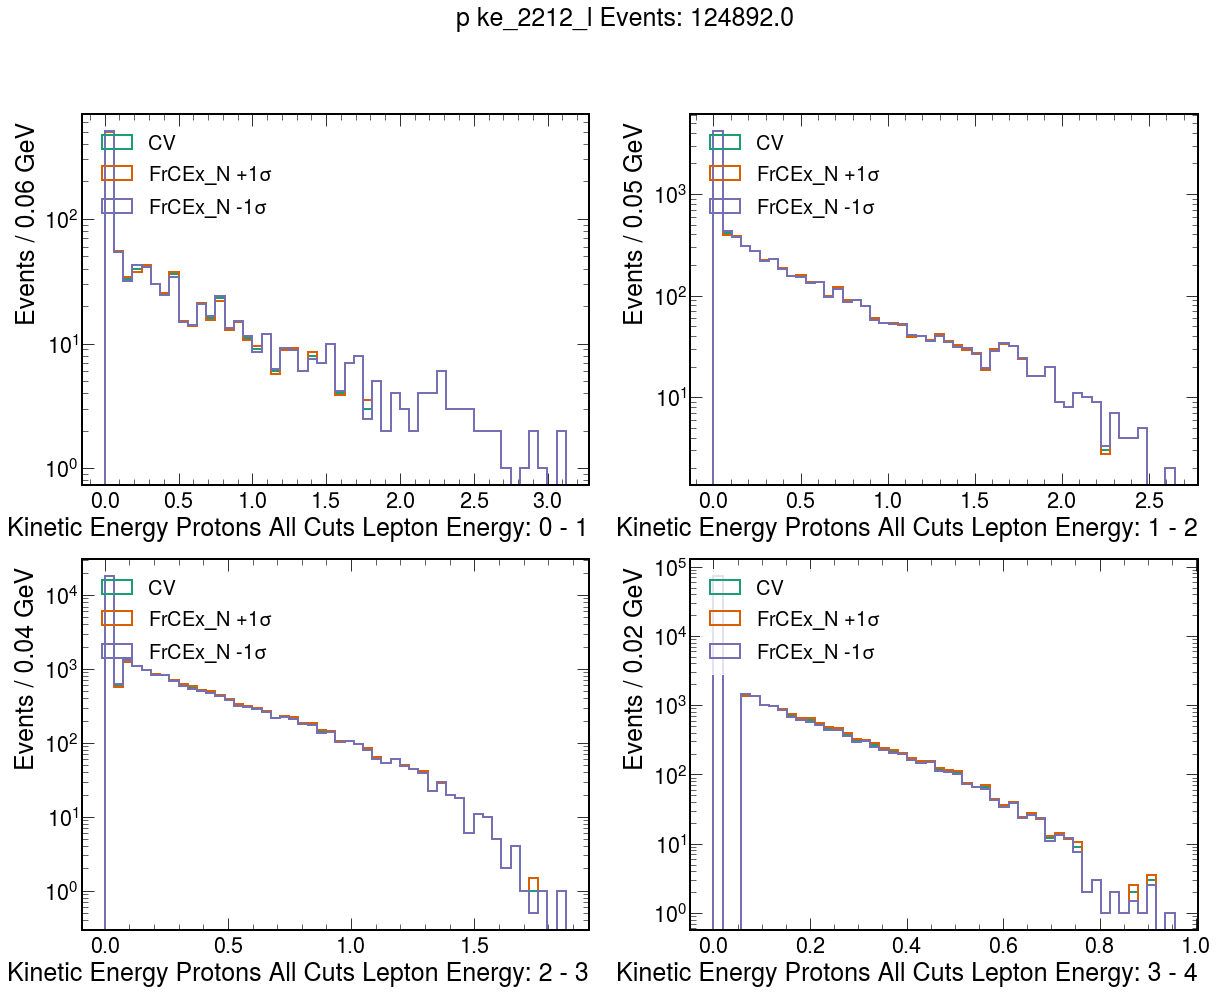

In [15]:
ax1, ax2, ax3, ax4 = plot_Ef(df_all_cuts, 2212, 'ke_2212_l', 'FrCEx_N', 'Kinetic Energy Protons All Cuts')


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[Text(0, 110, '110'),
 Text(0, 120, '120'),
 Text(0, 130, '130'),
 Text(0, 140, '140'),
 Text(0, 150, '150'),
 Text(0, 160, '160'),
 Text(0, 170, '170'),
 Text(0, 180, '180')]

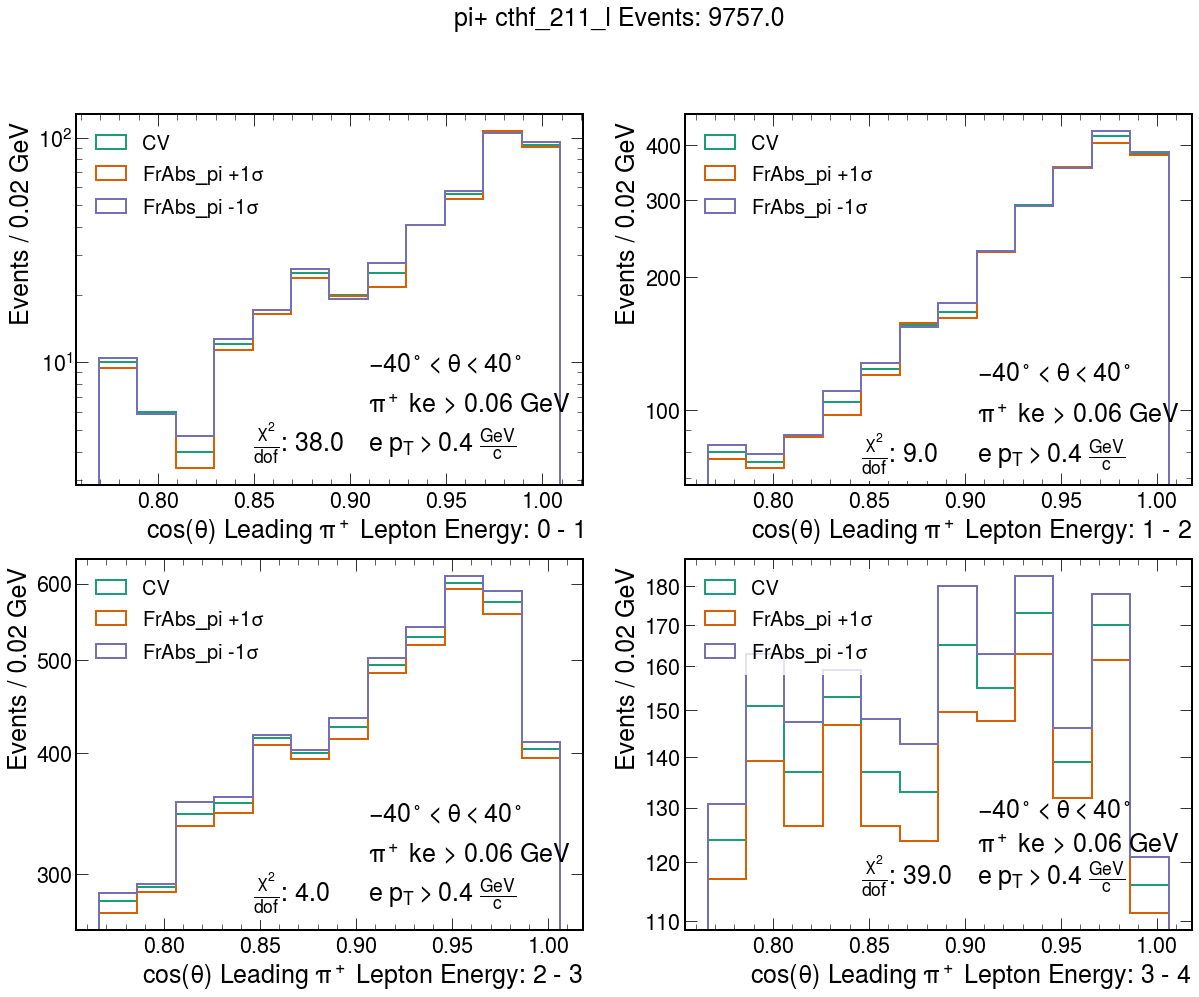

In [21]:
ax1, ax2, ax3, ax4 = plot_Ef(df_all_cuts, 211, 'cthf_211_l', 'FrAbs_pi', '$cos(\\theta)$ Leading $\pi^+$')
ax2.set_yticks([100,200,300,400])
ax2.set_yticklabels([100,200,300,400])

ax3.set_yticks([300,400, 500, 600])
ax3.set_yticklabels([300,400, 500, 600])

ax4.set_yticks([110, 120, 130, 140, 150,160, 170,180])
ax4.set_yticklabels([110, 120, 130, 140, 150,160, 170,180])